In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [ ]:
# Step 1: Load the Stanford Dogs dataset from TensorFlow Datasets
(train_data, test_data), info = tfds.load('stanford_dogs', split=['train', 'test'],
                                          with_info=True, as_supervised=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

In [3]:
# Step 2: Preprocess the data (Resize and Normalize)
IMG_SIZE = (224, 224)

def preprocess(image, label):
    image = tf.image.resize(image, IMG_SIZE)  # Resize images to 224x224
    image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0, 1]
    return image, label

train_data = train_data.map(preprocess).batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)
test_data = test_data.map(preprocess).batch(32).prefetch(buffer_size=tf.data.AUTOTUNE)

In [4]:
# Step 3: Load the pre-trained ResNet50 model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


#### IMP !!!
(Freezing Layers):

	•	You freeze the earlier layers of the pre-trained model only fine-tune the last 10 layers by setting layer.trainable = False for the frozen layers.
	•	To adjust the number of layers for fine-tuning, modify the range in base_model.layers[:-10]. For example, if you want to fine-tune the last 20 layers, change it to base_model.layers[:-20].

In [5]:
# Step 4: Filter Fine-Tuning (Freeze and Unfreeze Layers)
# Freeze all layers except the last 10 (you can modify this number to adjust the filters)
for layer in base_model.layers[:-5]:  # Fine-tuning only the last 10 layers
    layer.trainable = False  # Freeze earlier layers to keep pre-trained filters

# Adding new layers for fine-tuning the model for the Stanford Dogs classification task
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(info.features['label'].num_classes, activation='softmax')(x)

# Create the full model
model = Model(inputs=base_model.input, outputs=predictions)

In [6]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 25,808,888 (98.45 MB)

 Trainable params: 3,275,896 (12.50 MB)

 Non-trainable params: 22,532,992 (85.96 MB)

In [7]:
# Get the last layers
last_10_layers = base_model.layers[-5:]

# Print the names of the last layers one below the other
print("Last 10 layers in the base model:")
for layer in last_10_layers:
    print(layer.name)

Last 10 layers in the base model:
conv5_block3_2_relu
conv5_block3_3_conv
conv5_block3_3_bn
conv5_block3_add
conv5_block3_out


In [8]:
# Step 6: Compile the Model

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Step 7: Train the Top Layers

# Add callbacks for better training control
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001),
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
]

history = model.fit(train_data,
                    epochs=20,
                    validation_data=test_data,
                    callbacks=callbacks)

Epoch 1/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 3479s 9s/step - accuracy: 0.0115 - loss: 4.8140 - val_accuracy: 0.0241 - val_loss: 4.7030 - learning_rate: 1.0000e-04
Epoch 2/20
375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.0224 - loss: 4.6528

In [11]:
# Evaluate the Model

loss, accuracy = model.evaluate(test_data)
print(f'Validation Accuracy: {accuracy * 100:.2f}%')

269/269 ━━━━━━━━━━━━━━━━━━━━ 22s 82ms/step - accuracy: 0.0637 - loss: 4.4644
Validation Accuracy: 6.18%


In [ ]:
# Evaluate the Model on Training Data
loss, accuracy = model.evaluate(train_data)
print(f'Training Accuracy: {accuracy * 100:.2f}%')

In [ ]:
import matplotlib.pyplot as plt

# Plot accuracy and loss curves
def plot_history(history):
    plt.figure(figsize=(12, 4))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Accuracy over Epochs')
    plt.legend()

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss over Epochs')
    plt.legend()

    plt.show()

# Plot the results after training
plot_history(history)

#### IMPPP!!
(Unfreezing More Layers):

	• You can unfreeze more layers for further fine-tuning after initial training. Here, I’ve unfrozen the last 30 layers (base_model.layers[-30:]), but you can modify this value depending on how much of the model you want to fine-tune.
	• To target specific filters or layers, adjust the number of layers you unfreeze. This gradual unfreezing helps in adaptive filter fine-tuning.


In [12]:
# Step 9: Gradually Unfreeze More Layers for Further Filter Fine-Tuning
# Now we will unfreeze more layers for further fine-tuning
for layer in base_model.layers[-10:]:  # Unfreeze more layers as training progresses
    layer.trainable = True  # Fine-tuning filters in the last 30 layers

## Adafilter Implementation

In [ ]:
for layer in base_model.layers[-15:]:
    layer.trainable = True
    print(f"Layer {i}: {layer.name}, Trainable: {layer.trainable}")


In [13]:
# List all layers with their names and trainable status
for i, layer in enumerate(base_model.layers):
    print(f"Layer {i}: {layer.name}, Trainable: {layer.trainable}")

Layer 0: input_layer, Trainable: False
Layer 1: conv1_pad, Trainable: False
Layer 2: conv1_conv, Trainable: False
Layer 3: conv1_bn, Trainable: False
Layer 4: conv1_relu, Trainable: False
Layer 5: pool1_pad, Trainable: False
Layer 6: pool1_pool, Trainable: False
Layer 7: conv2_block1_1_conv, Trainable: False
Layer 8: conv2_block1_1_bn, Trainable: False
Layer 9: conv2_block1_1_relu, Trainable: False
Layer 10: conv2_block1_2_conv, Trainable: False
Layer 11: conv2_block1_2_bn, Trainable: False
Layer 12: conv2_block1_2_relu, Trainable: False
Layer 13: conv2_block1_0_conv, Trainable: False
Layer 14: conv2_block1_3_conv, Trainable: False
Layer 15: conv2_block1_0_bn, Trainable: False
Layer 16: conv2_block1_3_bn, Trainable: False
Layer 17: conv2_block1_add, Trainable: False
Layer 18: conv2_block1_out, Trainable: False
Layer 19: conv2_block2_1_conv, Trainable: False
Layer 20: conv2_block2_1_bn, Trainable: False
Layer 21: conv2_block2_1_relu, Trainable: False
Layer 22: conv2_block2_2_conv, Train

In [14]:
# Step 8: Function to get important filters for a layer
def get_important_filters(model, layer_name, top_n=10):
    layer = model.get_layer(name=layer_name)
    weights, _ = layer.get_weights()
    importance_scores = np.mean(np.abs(weights), axis=(0, 1, 2))
    important_filters = np.argsort(importance_scores)[-top_n:]
    return important_filters


In [16]:
# Step 9: Function to fine-tune specific filters of a given layer
def fine_tune_layer(model, layer_name, important_filters, learning_rate=0.0001):
    """
    Fine-tune specific filters of a given layer based on the important filters.
    """
    for i, layer in enumerate(model.layers):
        if 'conv' in layer.name and layer.name == layer_name:
            weights, bias = layer.get_weights()
            filter_mask = np.zeros_like(weights)
            filter_mask[:, :, :, important_filters] = 1  # Mask to only fine-tune the important filters
            layer.set_weights([weights * filter_mask, bias])
            layer.trainable = True
        else:
            layer.trainable = False

    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    return model

Getting important filters for layer: conv5_block3_3_conv
Important filters: [ 594 1948   89 1947  259 1109  936 1696 1803  521]


In [17]:
# Step 10: Fine-tune layers and compare accuracies

# Define the layers you want to fine-tune
layers_to_finetune = [
    'conv5_block3_3_conv',  # Last layer
    'conv4_block1_1_conv',  # Second-to-last layer
    'conv3_block4_3_conv'   # Third layer (you can choose any other layer)
]

# Store the results of accuracy after fine-tuning each layer
accuracies = {}

# Iterate through the layers and fine-tune them
for layer_name in layers_to_finetune:
    print(f"Fine-tuning {layer_name}...")

    # Get important filters for the current layer
    important_filters = get_important_filters(model, layer_name, top_n=10)

    # Fine-tune the model with the selected filters
    model_finetuned = fine_tune_layer(model, layer_name, important_filters, learning_rate=0.0001)

    # Train the model on the dataset
    history_fine_tune = model_finetuned.fit(train_data,
                                            epochs=5,
                                            validation_data=test_data,
                                            callbacks=callbacks,
                                            verbose=0)  # Set verbose to 0 to suppress output

    # Evaluate the model on the test set
    loss, accuracy = model_finetuned.evaluate(test_data, verbose=0)
    accuracies[layer_name] = accuracy * 100  # Store the accuracy in percentages

    print(f"Accuracy after fine-tuning {layer_name}: {accuracies[layer_name]:.2f}%")

In [18]:
# Step 11: Compare the results and select the best layer and filters
best_layer = max(accuracies, key=accuracies.get)
best_accuracy = accuracies[best_layer]

print("\nComparison of Fine-Tuning Results:")
for layer, accuracy in accuracies.items():
    print(f"{layer}: {accuracy:.2f}%")

print(f"\nBest Layer to Fine-Tune: {best_layer} with Accuracy: {best_accuracy:.2f}%")

Epoch 1/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 79s 179ms/step - accuracy: 0.0103 - loss: 20.4695 - val_accuracy: 0.0099 - val_loss: 7.3810 - learning_rate: 1.0000e-05
Epoch 2/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 92s 219ms/step - accuracy: 0.0109 - loss: 6.4300 - val_accuracy: 0.0096 - val_loss: 5.8805 - learning_rate: 1.0000e-05
Epoch 3/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 141s 218ms/step - accuracy: 0.0100 - loss: 5.8242 - val_accuracy: 0.0092 - val_loss: 5.6758 - learning_rate: 1.0000e-05
Epoch 4/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 83s 220ms/step - accuracy: 0.0118 - loss: 5.6151 - val_accuracy: 0.0113 - val_loss: 5.5521 - learning_rate: 1.0000e-05
Epoch 5/15
375/375 ━━━━━━━━━━━━━━━━━━━━ 122s 166ms/step - accuracy: 0.0118 - loss: 5.4897 - val_accuracy: 0.0125 - val_loss: 5.4597 - learning_rate: 1.0000e-05


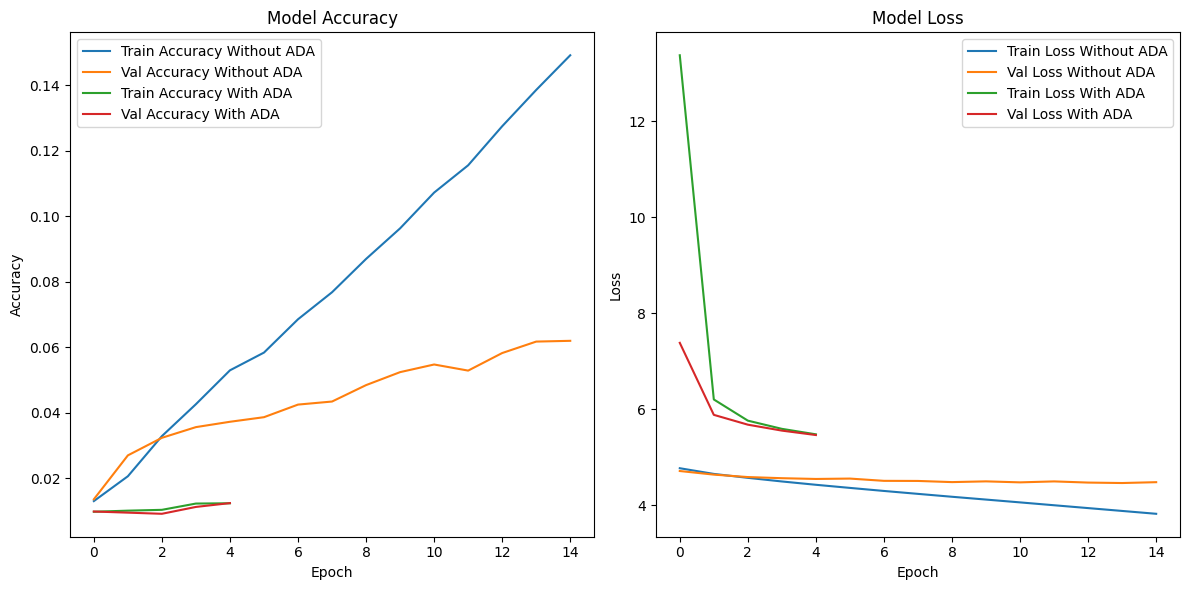

In [20]:
import matplotlib.pyplot as plt

# Assuming 'history' is the result of model.fit() without ADA
# and 'history_with_ada' is the result of model.fit() with ADA

# Plotting accuracy
plt.figure(figsize=(12, 6))

# Training Accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy Without ADA')
plt.plot(history.history['val_accuracy'], label='Val Accuracy Without ADA')
plt.plot(history_fine_tune.history['accuracy'], label='Train Accuracy With ADA')
plt.plot(history_fine_tune.history['val_accuracy'], label='Val Accuracy With ADA')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss Without ADA')
plt.plot(history.history['val_loss'], label='Val Loss Without ADA')
plt.plot(history_fine_tune.history['loss'], label='Train Loss With ADA')
plt.plot(history_fine_tune.history['val_loss'], label='Val Loss With ADA')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

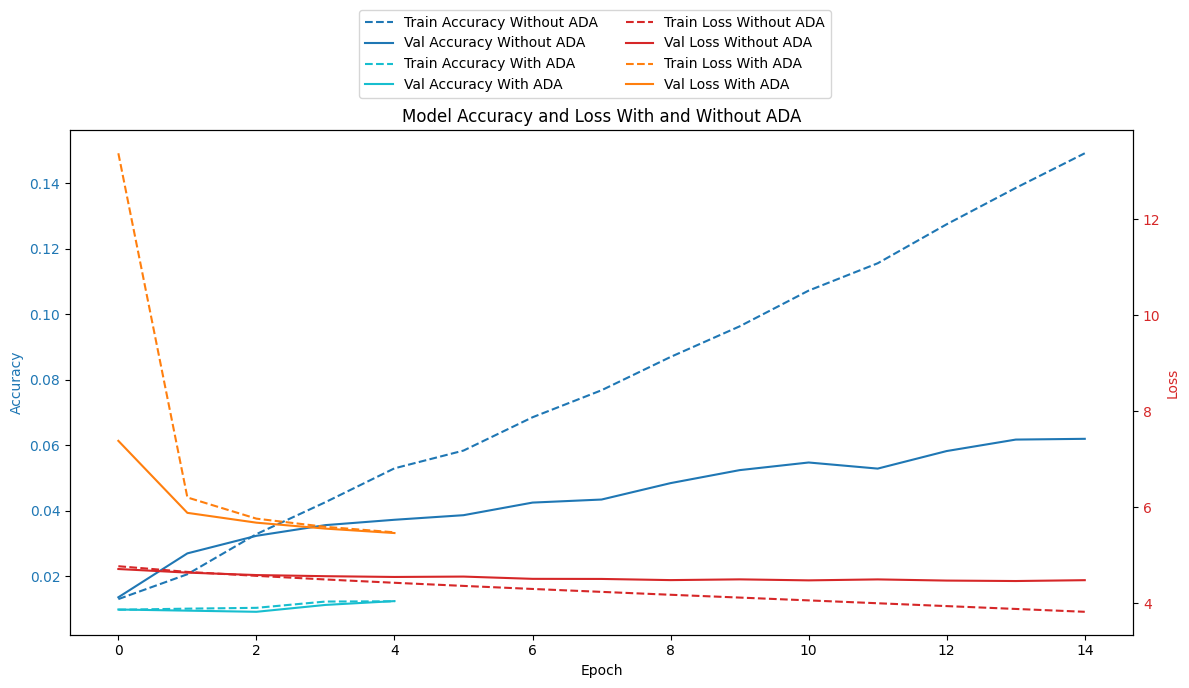

In [21]:
import matplotlib.pyplot as plt

# Create a figure and axis for plotting
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plotting accuracy on the first y-axis
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy', color='tab:blue')
ax1.plot(history.history['accuracy'], label='Train Accuracy Without ADA', color='tab:blue', linestyle='--')
ax1.plot(history.history['val_accuracy'], label='Val Accuracy Without ADA', color='tab:blue')
ax1.plot(history_fine_tune.history['accuracy'], label='Train Accuracy With ADA', color='tab:cyan', linestyle='--')
ax1.plot(history_fine_tune.history['val_accuracy'], label='Val Accuracy With ADA', color='tab:cyan')
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Create a second y-axis for loss
ax2 = ax1.twinx()
ax2.set_ylabel('Loss', color='tab:red')
ax2.plot(history.history['loss'], label='Train Loss Without ADA', color='tab:red', linestyle='--')
ax2.plot(history.history['val_loss'], label='Val Loss Without ADA', color='tab:red')
ax2.plot(history_fine_tune.history['loss'], label='Train Loss With ADA', color='tab:orange', linestyle='--')
ax2.plot(history_fine_tune.history['val_loss'], label='Val Loss With ADA', color='tab:orange')
ax2.tick_params(axis='y', labelcolor='tab:red')

# Add legends
fig.legend(loc="upper center", bbox_to_anchor=(0.5, 1.15), ncol=2)

# Add a title
plt.title('Model Accuracy and Loss With and Without ADA')

# Show the plot
plt.tight_layout()
plt.show()

In [22]:
# Calculate the final epoch accuracy for both models
train_acc_without_ada = history.history['accuracy'][-1]
val_acc_without_ada = history.history['val_accuracy'][-1]
train_acc_with_ada = history_fine_tune.history['accuracy'][-1]
val_acc_with_ada = history_fine_tune.history['val_accuracy'][-1]

# Calculate improvement
improvement_in_train_acc = train_acc_with_ada - train_acc_without_ada
improvement_in_val_acc = val_acc_with_ada - val_acc_without_ada

# Print the improvements
print(f"Improvement in Training Accuracy: {improvement_in_train_acc:.2%}")
print(f"Improvement in Validation Accuracy: {improvement_in_val_acc:.2%}")

Improvement in Training Accuracy: -13.68%
Improvement in Validation Accuracy: -4.95%


In [23]:
# Function to check model performance
def check_model_performance(train_acc, val_acc):
    if train_acc > 0.85 and abs(train_acc - val_acc) < 0.05:
        return "The model is performing well."
    elif train_acc < 0.7:
        return "The model is underfitting."
    elif train_acc - val_acc > 0.1:
        return "The model is overfitting."
    else:
        return "The model performance is acceptable but could be improved."


# Check performance without ADA
performance_without_ada = check_model_performance(train_acc_without_ada, val_acc_without_ada)
# Check performance with ADA
performance_with_ada = check_model_performance(train_acc_with_ada, val_acc_with_ada)

# Print the performance evaluations
print("\nPerformance without ADA:", performance_without_ada)
print("Performance with ADA:", performance_with_ada)


Performance without ADA: The model is underfitting.
Performance with ADA: The model is underfitting.
